In [1]:
import random
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
from gymnasium import Env
from gymnasium.spaces import Box, Dict
import ray
from ray import rllib
import pyarrow.parquet as pq
import ast

ModuleNotFoundError: No module named 'pyarrow'

In [ ]:
class Architecture:
    def __init__(self):
        self.space_flag = 0
        self.c_capacity, self.s_capacity = 1000, 100                                         # Capacity of the devices
        # self.a1, self.a2, self.a3, self.mc = 0.000125, 0.000010, 0.000200, 0.001           # Weight of every type of data
        self.weights = [0.0125, 0.0010, 0.0200, 0.1000]                                      # a1, a2, a3, mc
        self.lifetime = {'a1': 10000, 'a2': 20000, 'a3': 10000, 'mc': 1000}                  # Max lifetime of the different data types
        self.total_c = 2
        self.total_s = 6
        self.max_actions = 20

        self.devices = {}
        self.data = {
            'a1': {},
            'a2': {},
            'a3': {},
            'mc': {},
        }
        self.latencies = {}

        for i in range(self.total_c):
            for j in (self.data.keys()):
                self.data[j]['c'+str(i)] = 0
            self.devices['c'+str(i)] = {'a1': 0, 'a2': 0, 'a3': 0, 'mc': 0}
            self.latencies['c'+str(i)] = {}
        for i in range(self.total_s):
            for j in (self.data.keys()):
                self.data[j]['s'+str(i)] = 0
            self.devices['s'+str(i)] = {'a1': 0, 'a2': 0, 'a3': 0, 'mc': 0}
            self.latencies['s'+str(i)] = {}

        for i in self.latencies.keys():
            for j in self.latencies.keys():
                self.latencies[i][j] = 0

        self.data_types = []
        self.data_allocation = []
        self.data_times = []

        self.data_allocation_dict = []

        self.action_type = []
        self.action_device_dev = []
        self.action_device = []

        randomized = list(self.devices.keys())
        random.shuffle(randomized)

        bound = round(len(self.devices)/4)

        self.clusters = {
            'a1': randomized[:bound],
            'a2': randomized[bound:bound*2],
            'a3': randomized[bound*2:bound*3],
            'mc': randomized[bound*3:]
        }

        self.visualization()

    def to_int(self, device):
        return list(self.devices.keys()).index(device)

    def to_device(self, position):
        return list(self.devices.keys())[position]

    def construct_dictionaries(self):
        for i in self.data:
            for j in self.data[i]:
                self.data[i][j] = 0
        for i in self.devices:
            for j in self.devices[i]:
                self.devices[i][j] = 0
        for device, d_type in zip(self.data_allocation_dict,self.data_types):
            self.data[d_type][device] += 1
            self.devices[device][d_type] += 1

    def update(self, data_type, device):
        self.data_types.append(data_type)
        self.data_allocation_dict.append(device)
        self.data_allocation.append(self.to_int(device))
        self.data_times.append(0)
        self.devices[device][data_type] += 1
        self.data[data_type][device] += 1

    def heart_beat(self):
        deads = []
        for i in range(len(self.data_times)):
            self.data_times[i] += 1
            if self.data_times[i] == self.lifetime[self.data_types[i]]:
                deads.append(i)

        removed = 0
        for i in deads:
            self.devices[self.data_allocation_dict[i-removed]][self.data_types[i-removed]] -= 1
            self.data[self.data_types[i-removed]][self.data_allocation_dict[i-removed]] -= 1
            self.data_types.pop(i - removed)
            self.data_allocation_dict.pop(i - removed)
            self.data_allocation.pop(i - removed)
            self.data_times.pop(i - removed)
            removed += 1

    def free_space(self):
        load = {}
        for i in self.devices.keys():
            if list(i)[0] == 'c':
                load[i] = (self.c_capacity - sum([a*b for a,b in zip(list(self.devices[i].values()), self.weights)]))/self.c_capacity
            else:
                load[i] = (self.s_capacity - sum([a*b for a,b in zip(list(self.devices[i].values()), self.weights)]))/self.s_capacity
            if load[i] <= 0.2:
                self.space_flag = i
        return load

    def visualization(self):
        keys = list(self.devices.keys())
        cs = keys[:self.total_c]
        ss = keys[self.total_c:]

        colors = []
        sizes = []

        graph = nx.Graph()

        colors.append('lightblue')
        sizes.append(1000)
        index = 0
        for i in range(len(cs)):
            if i != len(cs)-1:
                colors.append('lightblue')
                sizes.append(1000)
                graph.add_edge(cs[i],cs[i+1])
                graph.add_weighted_edges_from([(cs[i],cs[i+1],10)])
                for j in range(int(len(ss)/self.total_c)):
                    colors.append('orange')
                    sizes.append(100)
                    graph.add_edge(cs[i],ss[index])
                    graph.add_weighted_edges_from([(cs[i],ss[index],4)])
                    index += 1
            else:
                graph.add_edge(cs[i],cs[0])
                graph.add_weighted_edges_from([(cs[i],cs[0],10)])
                for j in range(int(len(ss)/self.total_c)+len(ss)%self.total_c):
                    graph.add_edge(cs[i],ss[index])
                    graph.add_weighted_edges_from([(cs[i],ss[index],4)])
                    colors.append('orange')
                    sizes.append(100)
                    index += 1

        pos = nx.spring_layout(graph)  # Position nodes using a spring layout algorithm
        nx.draw(graph, pos, with_labels=True, node_size=sizes, node_color=colors, font_weight=12, font_color='black', edge_color='gray')
        edge_labels = nx.get_edge_attributes(graph, 'weight')
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

        plt.title("Architecture:")
        plt.axis('off')
        plt.show()

        for u in graph.nodes:
            shortest_paths = nx.shortest_path_length(graph, source=u, weight='weight')
            for v, weight in shortest_paths.items():
                self.latencies[u][v] = weight

    def compute_total_latency(self):
        total_latency = 0
        for i in range(len(self.action_type)):
            total_latency += sum([a*b for a,b in zip(self.data[self.action_type[i]].values(), self.latencies[self.action_device_dev[i]].values())])
        return total_latency

    def generate(self, operation):
        if operation == 'a1' or operation == 'a2' or operation == 'a3':
            for i in self.devices.keys():
                self.update(operation,i)
        elif operation == 'mc':
            for i in self.devices.keys():
                if list(i)[0] == 's':
                    self.update('mc',i)
        elif operation.split('_')[0] == 'ai':
            device=random.sample(list(self.clusters[operation.split('_')[1]]),1)
            self.action_device_dev.append(device[0])
            self.action_device.append(self.to_int(device[0]))
            self.action_type.append(operation.split('_')[1])
            difference = len(self.action_device_dev) - self.max_actions
            if difference >= 0:
                for i in range(difference):
                    self.action_device_dev.pop(0)
                    self.action_device.pop(0)
                    self.action_type.pop(0)

    def rl_update(self, allocation):
        allocation_dict = []
        for i in allocation:
            allocation_dict.append(self.to_device(i))
        self.data_allocation = allocation
        self.data_allocation_dict =allocation_dict
        self.construct_dictionaries()
        return self.free_space()

    def greedy_algorithm(self): # baseline?
        if self.space_flag == 0:
            allocation = []
            allocation_dev = []
            for i in self.data_types:
                allocation.append(self.to_int(random.sample(list(self.clusters[i]),1)[0]))
                allocation_dev.append(random.sample(list(self.clusters[i]),1)[0])
            self.data_allocation = allocation
            self.data_allocation_dict = allocation_dev
            self.construct_dictionaries()
            result = self.free_space()
        else:
            problematic_key = None
            for key, value in self.clusters.items():
                if self.space_flag in value:
                    problematic_key = key
                    break
            self.clusters[problematic_key].extend(element for element in self.devices if element[0]==('c'))
            self.space_flag = 0
            result = self.greedy_algorithm()

        return result

In [6]:
class SimulatedArchitecture(Env):
    def __init__(self, architecture, num_devices):
        self.arch = architecture
        self.num_devices = num_devices
        self.weights = self.arch.weights
        self.free_space = list(self.arch.free_space().values())
        self.reward = 0
        self.executions = ['a1','a2','mc','a1','ai_a2','mc','a3','ai_a1','mc','a1','ai_a3','mc','a2','a3','ai_a2','mc','ai_a1','a1','mc','ai_a3','ai_mc']
        self.len_executions = len(self.executions)
        self.index = 0
        self.observation_space = Dict()
        self.action_space = Box(low=0, high=self.num_devices-1, dtype=np.int32)
    def get_obs(self):
        return {"weights": self.weights,
                "free_space": self.free_space,
                "allocation": self.allocation,
                "last_calls": self.last_calls
                }
    def step(self, action):
        self.free_space = list(self.arch.rl_update(list(action)).values())
        latency = self.arch.compute_total_latency()
        self.reward = 0

        for i in self.free_space:
            if i <= 0.2:
                self.reward = -10
                break

        if self.reward != -10:
            self.reward = 4000000*(1/(latency+1)) + 0.5*(1/(np.std(self.free_space)+0.00001))              # With those weights, the scale of both latency and std is the same for high values while the latency is the only one taken into account in initial states (when there is plenty of space in the system and distribution is not that important)
        info = {}
        done = True

        return self.get_obs(), self.reward, done, info

    def render(self):
        pass
    def reset(self):
        if self.reward != -10:
            self.arch.generate(self.executions[self.index])
            self.arch.heart_beat()
            self.index = self.index + 1 if self.index < self.len_executions-1 else 0
        self.allocation = [self.arch.data_types,self.arch.data_allocation]
        self.last_calls = [self.arch.action_type,self.arch.action_device]
        self.action_space = Box(low=0, high=self.num_devices-1, shape=(len(self.allocation[1]),), dtype=np.int32)
    def close(self):
        pass

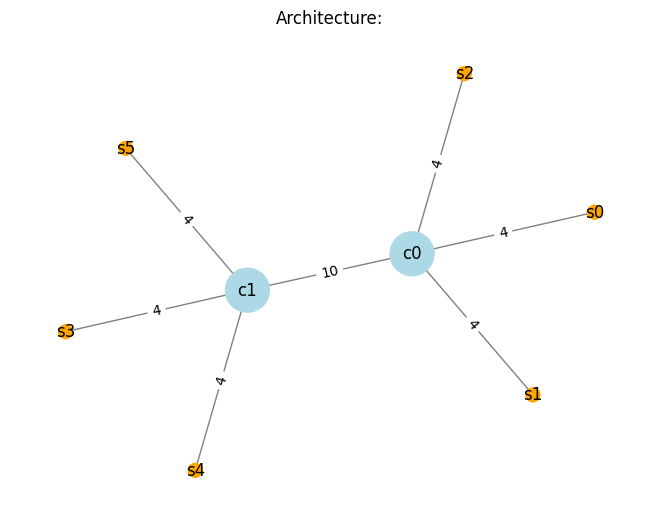

In [7]:
arch = Architecture()
simulation = SimulatedArchitecture(arch, 8)
# for i in range(1000):
#     simulation.reset()
#     simulation.step(simulation.action_space.sample())
# simulation.reset()
# simulation.step(simulation.action_space.sample())

In [8]:
def getData():
    observations_file_path = 'TFM/observations.csv'
    next_observations_file_path = 'TFM/next_observations.csv'
    actions_file_path = 'TFM/actions.parquet'
    rewards_file_path = 'TFM/rewards.parquet'

    observations_pd = pd.read_csv(observations_file_path)
    observations = observations_pd.to_dict(orient='records')
    next_observations_pd = pd.read_csv(next_observations_file_path)
    next_observations = next_observations_pd.to_dict(orient='records')
    actions_table = pq.read_table(actions_file_path)
    rewards_table = pq.read_table(rewards_file_path)
    actions = np.array(actions_table.to_pandas())
    rewards = np.array(rewards_table.to_pandas())

    return {"observations": observations, "actions":actions, "rewards": rewards, "next_observations":next_observations}

def processing(dataset):
    for i in range(len(dataset)):
        offline_dataset['observations'][i]["weights"] = ast.literal_eval(offline_dataset['observations'][i]["weights"])
        offline_dataset['observations'][i]["free_space"] = ast.literal_eval(offline_dataset['observations'][i]["free_space"])
        offline_dataset['observations'][i]['allocation'] = ast.literal_eval(offline_dataset['observations'][i]['allocation'])
        offline_dataset['observations'][i]["last_calls"] = ast.literal_eval(offline_dataset['observations'][i]["last_calls"])
        offline_dataset['next_observations'][i]["weights"] = ast.literal_eval(offline_dataset['next_observations'][i]["weights"])
        offline_dataset['next_observations'][i]["free_space"] = ast.literal_eval(offline_dataset['next_observations'][i]["free_space"])
        offline_dataset['next_observations'][i]['allocation'] = ast.literal_eval(offline_dataset['next_observations'][i]['allocation'])
        offline_dataset['next_observations'][i]["last_calls"] = ast.literal_eval(offline_dataset['next_observations'][i]["last_calls"])

In [9]:
offline_dataset = getData()

In [10]:
processing(offline_dataset)

In [22]:
from ray.rllib.utils import check_env

architecture = Architecture()
simulated_aces = SimulatedArchitecture(architecture,8)
# check_env(simulated_aces)

ValueError: Traceback (most recent call last):
  File "/home/rcalzada/.local/lib/python3.10/site-packages/tree/__init__.py", line 284, in assert_same_structure
    _tree.assert_same_structure(a, b, check_types)
ValueError: The two structures don't have the same nested structure.

First structure: type=NoneType str=None

Second structure: type=OrderedDict str=OrderedDict()

More specifically: Substructure "type=OrderedDict str=OrderedDict()" is a sequence, while substructure "type=NoneType str=None" is not

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/utils/pre_checks/env.py", line 82, in check_env
    check_gym_environments(env)
  File "/home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/utils/pre_checks/env.py", line 205, in check_gym_environments
    temp_sampled_reset_obs = convert_element_to_space_type(
  File "/home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/utils/spaces/space_utils.py", line 378, in convert_element_to_space_type
    return tree.map_structure(map_, element, sampled_element, check_types=False)
  File "/home/rcalzada/.local/lib/python3.10/site-packages/tree/__init__.py", line 433, in map_structure
    assert_same_structure(structures[0], other, check_types=check_types)
  File "/home/rcalzada/.local/lib/python3.10/site-packages/tree/__init__.py", line 288, in assert_same_structure
    raise type(e)("%s\n"
ValueError: The two structures don't have the same nested structure.

First structure: type=NoneType str=None

Second structure: type=OrderedDict str=OrderedDict()

More specifically: Substructure "type=OrderedDict str=OrderedDict()" is a sequence, while substructure "type=NoneType str=None" is not
Entire first structure:
.
Entire second structure:
OrderedDict()

The above error has been found in your environment! We've added a module for checking your custom environments. It may cause your experiment to fail if your environment is not set up correctly. You can disable this behavior via calling `config.environment(disable_env_checking=True)`. You can run the environment checking module standalone by calling ray.rllib.utils.check_env([your env]).

2023-05-30 20:57:49,651	INFO worker.py:1553 -- Started a local Ray instance.
(RolloutWorker pid=3996752) /home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/models/tf/misc.py:17: RuntimeWarning: divide by zero encountered in divide
(RolloutWorker pid=3996752)   out *= std / np.sqrt(np.square(out).sum(axis=0, keepdims=True))
(RolloutWorker pid=3996752) [2023-05-30 20:57:57,383 E 3996752 3997025] logging.cc:97: Unhandled exception: N4dnnl5errorE. what(): could not create a descriptor for an inner product forward propagation primitive
(RolloutWorker pid=3996752) [2023-05-30 20:57:57,513 E 3996752 3997025] logging.cc:104: Stack trace: 
(RolloutWorker pid=3996752)  /home/rcalzada/.local/lib/python3.10/site-packages/ray/_raylet.so(+0xd508da) [0x7f5c50f508da] ray::operator<<()
(RolloutWorker pid=3996752) /home/rcalzada/.local/lib/python3.10/site-packages/ray/_raylet.so(+0xd53098) [0x7f5c50f53098] ray::TerminateHandler()
(RolloutWorker pid=3996752) /usr/lib/libstdc++.so.6(+0xa6d0c) [0

KeyboardInterrupt: 

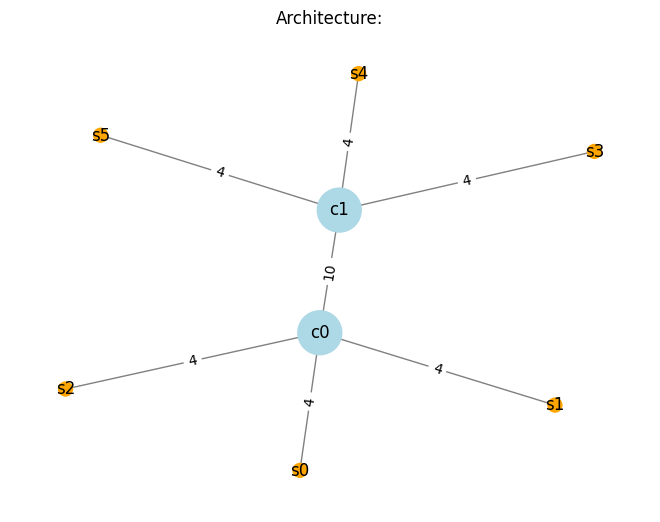

In [20]:
from ray.tune.registry import register_env
from gymnasium.wrappers import EnvCompatibility
from ray.rllib.algorithms.ppo import PPOConfig
import ray

ray.shutdown()
architecture = Architecture()
simulated_aces = SimulatedArchitecture(architecture,8)
def env_creator(env_config):
    return EnvCompatibility(simulated_aces)

register_env("ACES", env_creator)

config = (
    PPOConfig()
    .environment("ACES",disable_env_checking=True)
    .rollouts(num_rollout_workers=10,
              num_envs_per_worker=5) # Max = 60
    .resources(num_gpus=0,
               # num_cpus_per_worker=20
               )
    .training(entropy_coeff=0.02)
)

algorithm = config.build()

for i in tqdm(range(10)):
    result = algorithm.train()